In [149]:
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib as mlp
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datapath = "../../MODIS-Aqua-SST-ChlorA-BBT/output/"

In [3]:
import os 

In [7]:
# Leyendo 2018
i = 0
datasets = []
for filename in os.listdir(datapath):
    if "SST" in filename and "MODA2018" in filename:
        dataset = xa.open_dataset(datapath + filename)
        datasets.append(dataset)
        i += 1

In [27]:
datasets = sorted(datasets, key= lambda x: int(x.attrs["product_name"][1:8]) ) 

In [129]:
datasets[0].attrs["time_coverage_start"][0:10]

'2018-01-01'

In [37]:
# Confirmando que usan las mismas coordenadas
str(datasets[0].lat) == str(datasets[50].lat)

True

In [39]:
# Confirmando que usan las mismas coordenadas
str(datasets[0].lon) == str(datasets[150].lon)

True

In [131]:
concat = xa.concat([x["sst"] for x in datasets], pd.Index(data = pd.to_datetime([x.attrs["time_coverage_start"][0:10] for x in datasets]), name="date" ) )

In [132]:
def countnas(x, axis):
    return np.sum(np.isnan(x), axis)
    
cnas = concat.reduce(dumpx, dim="date")

Text(0.5, 1.0, 'NAs count per pixel')

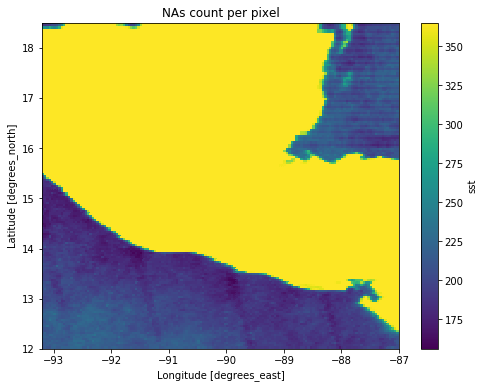

In [141]:
mlp.rcParams["figure.figsize"] = (8,6)

cnas.plot()
plt.title("NAs count per pixel")


In [236]:
lat, lon = (13.5, -90.5)

In [237]:
# Tomando un punto al azar en la costa sur, contando los NAs (casi la mitad)
np.sum(np.isnan(concat.sel(lat = lat, lon=lon, method="nearest")).values) / 365

0.4904109589041096

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


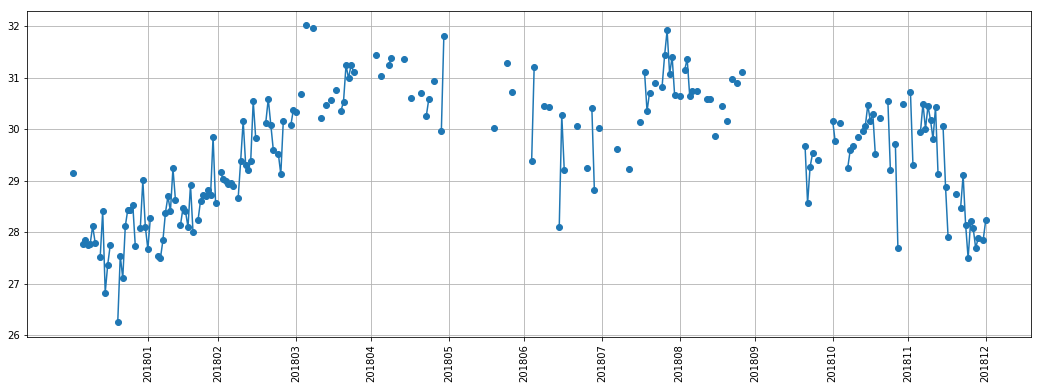

In [238]:
# Tomando un punto al azar en la costa sur, graficando
mlp.rcParams["figure.figsize"] = (18, 6)
plt.plot(concat.date.values, concat.sel(lat = lat, lon=lon, method="nearest").values, marker="o")
#[plt.axvline(x, c="red") for x in np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31]) ]
plt.grid("on")
index = pd.DatetimeIndex(start="2018-01-01", periods=12, freq="1M")
plt.xticks(index, index.map(lambda x: x.year *100 + x.month), rotation=90)
None

In [239]:
monthlymeans = concat.groupby("date.month").mean(dim="date")

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [240]:
monthlystd = concat.groupby("date.month").std(dim="date")
monthlyn = concat.groupby("date.month").count(dim="date")
stderr = 2* monthlystd / np.sqrt(monthlyn)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


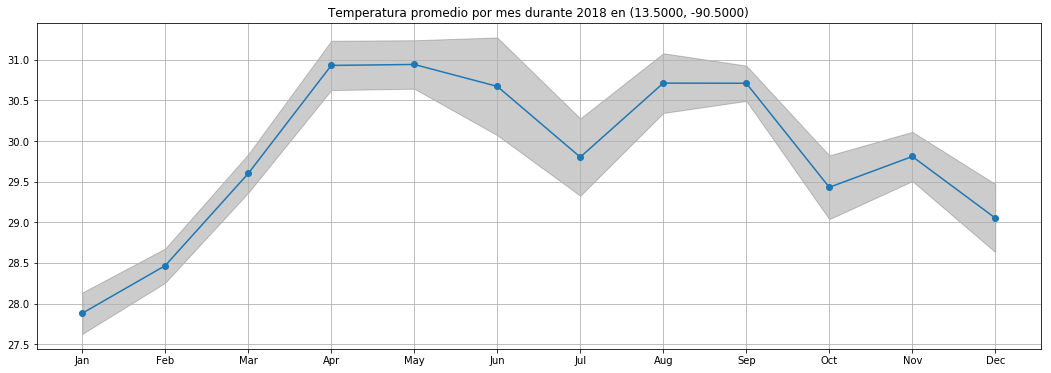

In [241]:
# Tomando un punto al azar en la costa sur, graficando
mlp.rcParams["figure.figsize"] = (18, 6)
ax = plt.subplot(111)
x = [calendar.month_abbr[i] for i in monthlymeans.month.values]
y = monthlymeans.sel(lat = lat, lon=lon, method="nearest").values
err = stderr.sel(lat = lat, lon=lon, method="nearest").values
plt.plot(x, monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o")
#plt.errorbar([calendar.month_abbr[i] for i in monthlymeans.month.values], monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", capsize=15,
#             yerr= stderr.sel(lat = lat, lon=lon, method="nearest").values)
plt.fill_between(x, y+err, y-err, color="black", alpha=0.2)

plt.grid("on")
plt.title("Temperatura promedio por mes durante 2018 en ({0:.4f}, {1:.4f})".format(lat,lon))
#ax = ax.twinx()
#ax.plot(monthlystd.month.values, monthlystd.sel(lat = lat, lon=lon, method="nearest").values, marker="o", c = "red")
#ax.tick_params(axis='y', labelcolor="red")

None

In [198]:
import calendar

In [214]:
calendar.month_abbr